In [1]:
from lsst.daf.butler import Butler
from astropy.table import Table, vstack
from astropy.io import fits
import requests
import re
import matplotlib.pyplot as plt
import traceback
import numpy
import matplotlib

In [57]:
repo_path = "/repo/ir2"
butler = Butler(repo_path,collections=[
    #'LSSTCam/photodiode',
    'LSSTCam/raw/all'
    ],instrument='LSST-TS8')
registry = butler.registry

Here is the list of the runs
```
7259D 2023/11/20	B protocol with the BOT projector, v26noRG
7261D 2023/11/21	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt150.seq
7263D 2023/11/21	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt300.seq
7264D 2023/11/21	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt450.seq
7265D 2023/11/21	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt600.seq
7266D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750.seq
7267D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750_iso1_140.seq
7268D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750_iso1_210.seq
7269D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750_iso1_70.seq
7270D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750_iso2_150.seq
7271D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750_iso2_300.seq
7272D 2023/11/22	B protocol with the BOT projector, FP_ITL_2s_ir2_v27_rt750_iso2_450.seq
```
And explore what's been produced by the standard pipelines

In [58]:
list(registry.queryCollections("*7259*"))

['u/lsstccs/bias_7259D_w_2023_41/20231121T020845Z',
 'u/lsstccs/bias_7259D_w_2023_41/20231121T023556Z',
 'u/lsstccs/bias_7259D_w_2023_41/20231121T061706Z',
 'u/lsstccs/dark_7259D_w_2023_41/20231121T065917Z',
 'u/lsstccs/flat_7259D_w_2023_41/20231121T071446Z',
 'u/lsstccs/defects_7259D_w_2023_41/20231121T072019Z',
 'u/lsstccs/ptc_7259D_w_2023_41/20231121T154839Z',
 'u/lsstccs/eo_read_noise_7259D_w_2023_41/20231121T160755Z',
 'u/lsstccs/eo_raft_amp_correlations_7259D_w_2023_41/20231121T160828Z',
 'u/lsstccs/eo_dark_current_7259D_w_2023_41/20231121T161026Z',
 'u/lsstccs/eo_raft_calib_mosaics_7259D_w_2023_41/20231121T161150Z',
 'u/lsstccs/eo_linearity_plots_7259D_w_2023_41/20231121T161242Z',
 'u/lsstccs/eo_divisadero_tearing_7259D_w_2023_41/20231121T161310Z',
 'u/lsstccs/eo_bright_defects_7259D_w_2023_41/20231121T160931Z',
 'u/lsstccs/eo_dark_defects_7259D_w_2023_41/20231121T161001Z',
 'u/lsstccs/eo_bf_analysis_7259D_w_2023_41/20231121T161337Z',
 'u/lsstccs/eo_eper_7259D_w_2023_41/20231121

Let's explore read noise first and ptc products might be also intesresting to look at

In [59]:
collections='u/lsstccs/eo_read_noise_7259D_w_2023_41'
for results in registry.queryDatasets(...,collections=collections).byParentDatasetType():
    n=results.count(exact=False)
    if n==0:
        continue
    print(results.parentDatasetType.name, n)

camera 1
raw 908292
cpBiasProc 180
isr_metadata 1260
bias 9
isr_config 7
packages 8
isr_log 1620
cpBiasCombine_config 3
cpBiasCombine_metadata 9
cpBiasCombine_log 9
cpFlatMeasure_config 1
cpFlatCombine_config 1
cpFlatNorm_config 1
cpFlatProc 90
flatStats 90
cpFlatNormScales 1
cpFlatMeasure_metadata 90
cpFlatMeasure_log 90
flat 9
cpFlatCombine_metadata 9
cpFlatCombine_log 9
cpFlatNorm_metadata 1
cpFlatNorm_log 1
cpDark_config 1
cpDarkCombine_config 1
cpDarkIsr 81
cpDarkProc 81
cpDark_metadata 81
cpDark_log 81
dark 9
cpDarkCombine_metadata 9
cpDarkCombine_log 9
measureDefects_config 1
mergeDefects_config 1
cpDefectsProc 171
cpPartialDefects 171
measureDefects_metadata 171
measureDefects_log 171
defects 9
mergeDefects_metadata 9
mergeDefects_log 9
ptcExtract_config 1
ptcSolve_config 1
cpPtcProc 738
ptcExtract_metadata 9
ptcExtract_log 9
ptc 9
ptcSolve_metadata 9
ptcSolve_log 9
photodiode 9358
cpPtcExtract 738
ptcNormalizedCov01 9
ptcPlot_log 9
ptcARelativeBias 9
ptcAandBMatrices 9
ptcCov1

In [5]:
def getnoisedata( collections ):
    # construct tables from eo_read_noise dataset
    prototable=[]
    for datasetref in list(registry.queryDatasets('eo_read_noise', collections=collections)):
        prototable.append(Table.from_pandas(butler.get(datasetref)))
    table=vstack(prototable)

    # putting seqeuncer file information from their header
    itr=registry.queryDatasets( 'isr_metadata', collections=collections, findFirst=True)
    with fits.open(butler.getURI('raw',dataId=list(itr.dataIds)[0],collections=collections).geturl(),use_fsspec=True,
              fsspec_kwargs = {
                  "endpoint_url": "https://s3dfrgw.slac.stanford.edu"              }
             ) as fh:
            header=fh[0].header
    
    table.meta['SEQFILE']=header['SEQFILE']

    # retrieving the sequncer paramters from github
    gitbase='https://raw.githubusercontent.com/lsst-camera-dh/sequencer-files/long_readout_2023'
    if table.meta['SEQFILE']=='FP_ITL_2s_ir2_v26.seq':
        r = requests.get(f"{gitbase}/run6/FP_ITL_2s_ir2_v26.seq")
    else:
        r = requests.get(f"{gitbase}/long_readout_2023/{table.meta['SEQFILE']}")    
    
    keys = ["ISO1", "ISO2", "RampTime"]
    for akey in keys:
        table.meta[akey]=int(re.search(f'{akey}: \s*([0-9]*) ns',r.text)[1])

    return table

In [6]:
runs=["7259D", "7261D", "7263D", "7264D", "7265D", "7266D", "7267D", "7268D", "7269D", "7270D", "7271D", "7272D"]
tables ={}
for run in runs:
    try:
        tables[run]=getnoisedata(list(registry.queryCollections(f"*eo_read_noise_{run}*")))
    except:
        traceback.print_exc()

/tmp/ipykernel_17624/3921234327.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


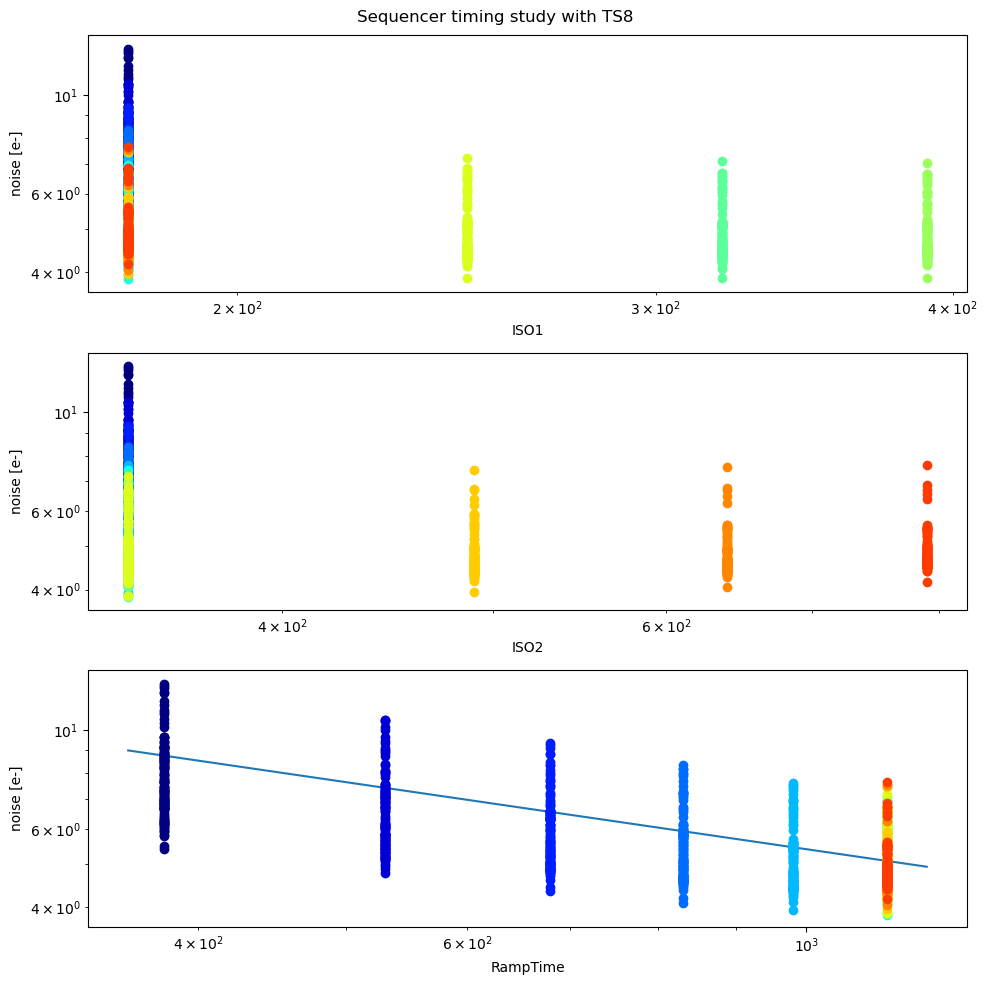

In [56]:
fig,axs=plt.subplots(3,1,figsize=(10,10),sharex=False,sharey=False)

cmap = matplotlib.cm.get_cmap('jet')
for ax, key in zip(axs,["ISO1", "ISO2", "RampTime"]):
    for i, arun in enumerate(runs[:]):
        btable=tables[arun]
        tg=btable.group_by(['det_name','amp_name'])
        for ch, group in zip(tg.groups.keys, tg.groups):
#            print(ch)
            if ch['det_name']=='RTM-004_S00':
                continue
            noise=group['read_noise']
            ax.errorbar(btable.meta[key], numpy.mean(noise), yerr=numpy.std(noise), fmt="o", c=cmap(float(i/(len(runs)+1))))

    ax.set_xlabel(key)
    ax.set_ylabel("noise [e-]")
    ax.loglog()
x=numpy.arange(360,1200)
axs[2].plot(x,9*(x/360)**-0.5)
fig.suptitle('Sequencer timing study with TS8')
plt.tight_layout()

In [8]:
btable

run,exposure_id,det_name,amp_name,read_noise,bias_level
str5,int64,str11,str3,float64,float64
7272D,2023112201225,RTM-004_S00,C10,5.372871445989642,24510.0
7272D,2023112201225,RTM-004_S00,C11,5.58653909197973,23474.0
7272D,2023112201225,RTM-004_S00,C12,5.637154141510038,23936.0
7272D,2023112201225,RTM-004_S00,C13,5.756849129704047,23746.0
7272D,2023112201225,RTM-004_S00,C14,5.807904248062921,23272.0
7272D,2023112201225,RTM-004_S00,C15,5.8879586680649085,23711.0
7272D,2023112201225,RTM-004_S00,C16,5.4306185167745955,24564.0
7272D,2023112201225,RTM-004_S00,C17,3.5711393607638997,27946.0
7272D,2023112201225,RTM-004_S00,C07,26.514547819533348,32204.0


PTC

In [9]:
num=22


In [10]:
list(registry.queryCollections("*ptc*7259*"))
collections='u/lsstccs/ptc_7259D_w_2023_41'
for results in registry.queryDatasets(...,collections=collections).byParentDatasetType():
    n=results.count(exact=False)
    if n==0:
        continue
    print(results.parentDatasetType.name, n)

camera 1
raw 908292
cpBiasProc 180
isr_metadata 1260
bias 9
isr_config 7
packages 7
isr_log 1620
cpBiasCombine_config 3
cpBiasCombine_metadata 9
cpBiasCombine_log 9
cpFlatMeasure_config 1
cpFlatCombine_config 1
cpFlatNorm_config 1
cpFlatProc 90
flatStats 90
cpFlatNormScales 1
cpFlatMeasure_metadata 90
cpFlatMeasure_log 90
flat 9
cpFlatCombine_metadata 9
cpFlatCombine_log 9
cpFlatNorm_metadata 1
cpFlatNorm_log 1
cpDark_config 1
cpDarkCombine_config 1
cpDarkIsr 81
cpDarkProc 81
cpDark_metadata 81
cpDark_log 81
dark 9
cpDarkCombine_metadata 9
cpDarkCombine_log 9
measureDefects_config 1
mergeDefects_config 1
cpDefectsProc 171
cpPartialDefects 171
measureDefects_metadata 171
measureDefects_log 171
defects 9
mergeDefects_metadata 9
mergeDefects_log 9
ptcExtract_config 1
ptcSolve_config 1
cpPtcProc 738
ptcExtract_metadata 9
ptcExtract_log 9
ptc 9
ptcSolve_metadata 9
ptcSolve_log 9
photodiode 9358
cpPtcExtract 738
ptcNormalizedCov01 9
ptcPlot_log 9
ptcARelativeBias 9
ptcAandBMatrices 9
ptcCov1

In [11]:
def getptcdata( collections ):
    # construct tables from eo_read_noise dataset
    prototable=[]
    for datasetref in list(registry.queryDatasets('ptc', collections=collections)):
        try:
            print(datasetref.dataId)
            tmptable=butler.get(datasetref).toTable()[0]
            det_name=list(registry.queryDimensionRecords("detector",
                                                instrument='LSST-TS8',
                                                where=f"detector.id={datasetref.dataId['detector']}"))[0].full_name
            tmptable.add_column(det_name,name='det_name')
            prototable.append(tmptable)
            print(len(tmptable.colnames))
        except:
            traceback.print_exc()            
    table=vstack(prototable)
    print(table)

    # putting seqeuncer file information from their header
    itr=registry.queryDatasets( 'isr_metadata', collections=collections, findFirst=True)
    with fits.open(butler.getURI('raw',dataId=list(itr.dataIds)[0],collections=collections).geturl(),use_fsspec=True,
              fsspec_kwargs = {
                  "endpoint_url": "https://s3dfrgw.slac.stanford.edu"              }
             ) as fh:
            header=fh[0].header
    
    table.meta['SEQFILE']=header['SEQFILE']
    table.add_column(header['RUNNUM'], name='run')

    # retrieving the sequncer paramters from github
    gitbase='https://raw.githubusercontent.com/lsst-camera-dh/sequencer-files/long_readout_2023'
    if table.meta['SEQFILE']=='FP_ITL_2s_ir2_v26.seq':
        r = requests.get(f"{gitbase}/run6/FP_ITL_2s_ir2_v26.seq")
    else:
        r = requests.get(f"{gitbase}/long_readout_2023/{table.meta['SEQFILE']}")    
    
    keys = ["ISO1", "ISO2", "RampTime"]
    for akey in keys:
        table.meta[akey]=int(re.search(f'{akey}: \s*([0-9]*) ns',r.text)[1])

    return table


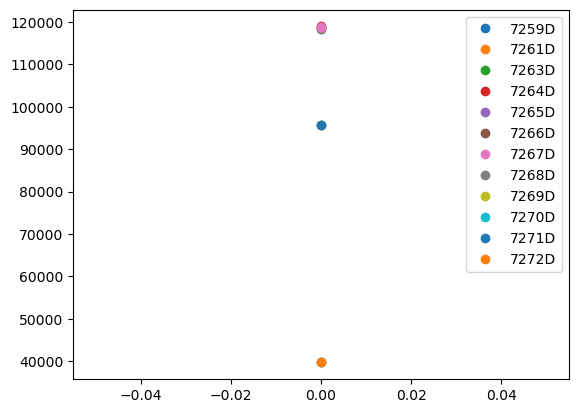

In [12]:
ptctables ={}
for run in runs:
    try:
        amp='C10'
        ptc=butler.get('ptc', instrument='LSST-TS8', detector=26, collections=(list(registry.queryCollections(f"*ptc_{run}_w_2023_41"))))
        plt.plot( ptc.ptcTurnoff[amp]*ptc.gain[amp], "o",label=run )
    except:
        traceback.print_exc()
plt.legend()

In [51]:
(list(registry.queryCollections(f"*ptc_{run}_w_2023_41")))

['u/lsstccs/ptc_7271D_w_2023_41']

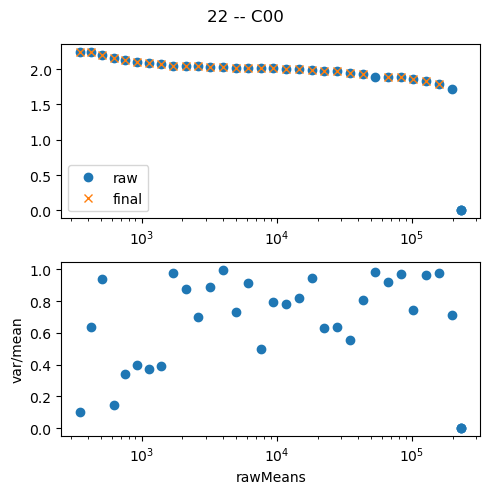

In [50]:
ptctables ={}
#for run in runs:
fig,axs=plt.subplots(2,1,figsize=(5,5),sharex=False,sharey=False)

detector=22
for run in ['7271D']:
    try:
        amp='C00'
        ptc=butler.get('ptc', instrument='LSST-TS8', detector=detector, collections=(list(registry.queryCollections(f"*ptc_{run}_w_2023_41"))))
        axs[0].plot( ptc.rawMeans[amp], ptc.rawVars[amp]/ptc.rawMeans[amp], "o",label=f"raw" )
        axs[0].plot( ptc.finalMeans[amp], ptc.finalVars[amp]/ptc.finalMeans[amp], "x",label=f"final" )
        axs[1].plot( ptc.rawMeans[amp], ptc.kspValues[amp], "o",label=f"raw" )
        
    except:
        traceback.print_exc()
axs[0].semilogx()
axs[1].semilogx()
axs[0].legend()
plt.suptitle(f"{detector} -- {amp}")
plt.xlabel('rawMeans')
plt.ylabel('var/mean')
plt.tight_layout()

In [52]:
ptc.ptcFitType

'EXPAPPROXIMATION'

In [38]:
list(registry.queryDimensionRecords("detector",
                          instrument='LSST-TS8' )) #, where='detector.raft="RTM-004"'))

[detector.RecordClass(instrument='LSST-TS8', id=0, full_name='RTM-002_S00', name_in_raft='S00', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=1, full_name='RTM-002_S01', name_in_raft='S01', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=2, full_name='RTM-002_S02', name_in_raft='S02', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=3, full_name='RTM-002_S10', name_in_raft='S10', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=4, full_name='RTM-002_S11', name_in_raft='S11', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=5, full_name='RTM-002_S12', name_in_raft='S12', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=6, full_name='RTM-002_S20', name_in_raft='S20', raft='RTM-002', purpose='SCIENCE'),
 detector.RecordClass(instrument='LSST-TS8', id=7, full_name='RTM-002_S21', 